# TP RNN 
# Using Many-to-One for movie rating predicton

For any remark or suggestion, please feel free to contact me at:
geoffroy.peeters@telecom-paristech.fr

Last edit: 2019/01/15 geoffroy.peeters@telecom-paristech.fr

### Objective:
We will implement two different networks to perform automatic rating (0 or 1) of a movie given the text of its review.
We will use the ```imdb``` (internet movie database) dataset.

The reviews are already available in the form of indexes that point to a word dictionary: each word is already encoded as an index in the dictionary.

### Import packages

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences

tf.set_random_seed(1)

In [2]:
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
  print('TPU not found')

Found TPU at: grpc://10.51.238.90:8470


## Parameters of the model

-  We only consider the ```top_words``` first words in the word dictionary
- We truncate/zerp-pad each sequence a length ```max_review_length````

In [0]:
top_words = 15000 
max_review_length = 250
INDEX_FROM = 3
epochs = 20

## Import IMDB data

In [4]:
# Import the IMDB data and only consider the ``top_words``` most used words
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, index_from=INDEX_FROM)

17465344/17464789 [==============================] - 0s 0us/step


In [5]:
X_train

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 

In [6]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

## Data content

- ```X_train``` and ```X_test``` are numpy arrays of lists. 
  - each item in a list is the index in the word dictionary. So that a list is the sequence of index of words.

- ```y_train``` and ```y_test``` are a numpy arrays of the same dimension as ```X_train``` and ```X_test``` 
  - they contains the values 0 (bad movie) or 1 (good movie)

type(X_train): <class 'numpy.ndarray'>
number of training sequences: X_train.shape: (25000,)
type(X_train[0]): <class 'list'>
length of the first training sequence: len(X_train[0]): 218
length of the second training sequence: len(X_train[0]): 189
list of data of the first training sequence: X_train[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104

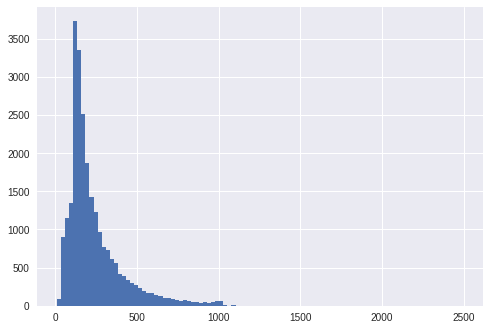

In [7]:
print("type(X_train):", type(X_train))
print("number of training sequences: X_train.shape:", X_train.shape)
print("type(X_train[0]):",type(X_train[0]))
print("length of the first training sequence: len(X_train[0]):",len(X_train[0]))
print("length of the second training sequence: len(X_train[0]):",len(X_train[1]))
print("list of data of the first training sequence: X_train[0]:", X_train[0] )
len_list = [len(train) for train in X_train]
print("maximum length of a training sequence:", max(len_list))

plt.hist(len_list, 100);

## Details of how the reviews are encoded

In [8]:
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[1000] ))

1646592/1641221 [==============================] - 0s 0us/step
<START> although i had seen <UNK> in a theater way back in <UNK> i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of <UNK> br br it turns out this is one of those films produced during the '80s that would go directly to video today the film stars champion gymnast kurt thomas as jonathan <UNK> recruited out of the blue to <UNK> the nation of <UNK> to enter and hopefully win the game a suicidal <UNK> <UNK> by the khan who encourages his people by yelling what sounds like <UNK> power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess <UNK> who never speaks or leaves the house once trained tries to blend in with the locals 

In [9]:
print("type(y_train):", type(y_train))
print("y_train.shape:", y_train.shape)

type(y_train): <class 'numpy.ndarray'>
y_train.shape: (25000,)


In [10]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (25000,)
y_test.shape: (25000,)


## Data processing

Sequences (represented as a list of values) in ```X_train``` represent the reviews.
They can have different length.
To train the network we should modify them so that they all have the same length.
We do this by:
- truncating the ones that are too long
- padding-with-zero them the ones that are too short.

This is obtained using ```sequence.pad_sequences``` of keras.

In [11]:
# truncate and pad input sequences
# define sequences

# CODE-RNN1-1
# --- START CODE HERE
X_train = pad_sequences(X_train,max_review_length)
X_test = pad_sequences(X_test,max_review_length)
# --- END CODE HERE

print("len(X_train[0]):", len(X_train[0]))
print("len(X_train[1]):", len(X_train[1]))
print("X_train[0]:", X_train[0])

len(X_train[0]): 250
len(X_train[1]): 250
X_train[0]: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     1    14    22    16
    43   530   973  1622  1385    65   458  4468    66  3941     4   173
    36   256     5    25   100    43   838   112    50   670     2     9
    35   480   284     5   150     4   172   112   167     2   336   385
    39     4   172  4536  1111    17   546    38    13   447     4   192
    50    16     6   147  2025    19    14    22     4  1920  4613   469
     4    22    71    87    12    16    43   530    38    76    15    13
  1247     4    22    17   515    17    12    16   626    18     2     5
    62   386    12     8   316     8   106     5     4  2223  5244    16
   480    66  3785    33     4   130    12    16    38   619     5    25
   124    51    36   135    48    25  1415    33     6    22    12   2

## First model

In the first model, we will simply 
- learn a word embedding  (```Embedding``` layer in keras) and apply it to each of item of a sequence, 
  -  in keras, embedding is not a matrix going from one-hot-encoding to embedding, it is a layer that goes from index-in-word-dictionary to embedding
  - the embedding goes from ```top_words``` dimensions to  ```embedding_vector_length``` dimensions
- average the embedding obtained for each word of a sequence over all words of the sequence (you should use ```K.mean``` and ```Lambda``` from the keras backend)
- apply a fully connected (```Dense``` layer in keras) which output activation is a sigmoid ()predicting the 0 or 1 rating)



In [0]:
K.clear_session()

In [13]:
# create the model
embedding_vector_length = 32

# CODE-RNN1-2
# --- START CODE HERE
def function1(x):
    x = K.mean(x, axis=1)
    return x
  
model = Sequential()

model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model.add(Lambda(function1))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 32)           480000    
_________________________________________________________________
lambda (Lambda)              (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 480,033
Trainable params: 480,033
Non-trainable params: 0
_________________________________________________________________


In [14]:
# compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
    tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))

tpu_model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_test, y_test))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.51.238.90:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 5350107768229588125)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8609402521467275766)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9934158498571369711)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1,

## Results

After only 3 epochs, you should obtain an accuracy around 84% for the test data.

In [15]:
# Final evaluation of the model
scores = tpu_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(4,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(4, 250), dtype=tf.float32, name='embedding_input_10'), TensorSpec(shape=(4, 1), dtype=tf.float32, name='dense_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for embedding_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f2624447e48> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 1.1577911376953125 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(1,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(1, 250), dtype=tf.float32, name='embedding_input_10'), TensorSpec(shape=(1, 1), dtype=tf.float32, name='dense_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for embedding_input
INFO:tensorflow:KerasCr

## Using the trained embedding to find equivalence between words

Since the embedding is part of the models, we can look at the trained embedding matrix $E$ and use it to get the most similar words (according to the trained matrix $E$) in the dictionary.
Use the weights of the ```Embedding``` layer to find the most similar words to ```amazing```. We will use an Euclidean distance for that.
- Retrieve the weights of the ```Embedding layer```
- Get the position of ```amazing``` in the dictionary
- Get the word-embedding of ```amazing```
- Find (using Euclidean distance), the closest embedded-words to ```amazing```

In [16]:
# CODE-RNN1-3
# --- START CODE HERE
weights = tpu_model.layers[1].get_weights()[0]

def closest_node(node, nodes, id_to_word):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    pos = np.argsort(dist_2)[:5]
    list_words = []
    for p in pos :
      list_words.append(id_to_word.get(p))
    return pos, list_words
 
closest_word = closest_node(weights[word_to_id['amazing']], weights, id_to_word)
closest_word
# --- END CODE HERE

(array([  480,  6324,  1119,  3678, 10165]),
 ['amazing', 'colleagues', '15', 'mate', '1952'])

## Second model

In the second model, we will replace
- average the obtained embedding over the sequence (use ```K.mean``` and ```Lambda```from keras backend)
- by a RNN layer (more precisely an ```LSTM```) in a Many-To-One configuration with $n_a=100$


In [0]:
K.clear_session()

In [18]:
# create the model

# CODE-RNN1-4
# --- START CODE HERE
model = Sequential()

model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.summary()
# --- END CODE HERE

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 32)           480000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 533,301
Trainable params: 533,301
Non-trainable params: 0
_________________________________________________________________


In [19]:
# compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
    tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))

tpu_model.fit(X_train, y_train, epochs=epochs, batch_size=256, validation_data=(X_test, y_test))


INFO:tensorflow:Querying Tensorflow master (grpc://10.51.238.90:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 5350107768229588125)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8609402521467275766)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9934158498571369711)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1910827148762559825)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 6633747291963205247)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/j

## Results

After only 3 epochs, you should obtain an accuracy around 88% for the test data.

In [20]:
# Final evaluation of the model
scores = tpu_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(4,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(4, 250), dtype=tf.float32, name='embedding_input_10'), TensorSpec(shape=(4, 1), dtype=tf.float32, name='dense_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for embedding_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f261ad4de80> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.3865110874176025 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(1,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(1, 250), dtype=tf.float32, name='embedding_input_10'), TensorSpec(shape=(1, 1), dtype=tf.float32, name='dense_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for embedding_input
INFO:tensorflow:KerasCr